In [15]:
# %% importing libraries
import os
from matplotlib.pyplot import title
root_path = r'/opt/app/mpidatasci/prakash.tiwari/'
os.chdir(root_path)

import sys
sys.path.append("/opt/app/mpidatasci/")
import numpy as np
import pandas as pd
import pickle
from src.preparation import ren_standard_data
from src.preprocessing import phonetic_transform, FeatureSelector, DirectMatchFeature
from src.preprocessing import FuzzyFeatures, AddressComponent, DirectcompareFeature , FuzzyFeatures_Set
# from src.preprocessing import somenew
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')
import time
from src.no_match_batch import return_batch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from src.model_eval import declie_plot
import seaborn as sns
from src.model_eval import evaluate_model
from src.util import read_yaml
import seaborn as sns
from src.experiment_tracking import log_experiment
import matplotlib.pyplot as plt

In [16]:
import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


pd.set_option('display.max_columns', None)

In [17]:
configuration=read_yaml("config/config.yaml")
configuration

{'package_name': 'HFCA Non-P',
 'package_root': '/opt/app/mpidatasci/prakash.tiwari/',
 'mlflow_path': '/opt/app/mpidatasci/prakash.tiwari/mlflow/mlruns/',
 'artifact_path': '/opt/app/mpidatasci/prakash.tiwari/artifacts/',
 'notebook_path': '/opt/app/mpidatasci/prakash.tiwari/Non_P_HFCA_mlflow_wrapping.ipynb',
 'timeout': 120,
 'test': '1234'}

In [18]:
# %%
training_data = "data/training.pkl"
total = pickle.load(open(training_data,'rb'))

In [19]:
total.columns

Index(['CLAIM_TYPE_C', 'PROVIDER_NAME_C', 'PROVIDER_FNAME_C',
       'PROVIDER_LNAME_C', 'ADDRESS_C', 'PROVIDER_ADD2_C', 'STATE_C', 'ZIP_C',
       'CITY_C', 'PROVIDER_MATCH_CODE_C', 'PROVIDER_RIMS_ID_C',
       'ORIGINAL_PROVIDER_TAX_ID_C', 'ORIGINAL_PROVIDER_ZIP_CODE_C',
       'PROVIDER_NAME_RENDERING_C', 'PROVIDER_FIRST_NAME_RENDERING_C',
       'PROVIDER_LAST_NAME_RENDERING_C', 'PROVIDER_TAX_ID_RENDERING_C',
       'PROVIDER_ADD1_RENDERING_C', 'PROVIDER_ADD2_RENDERING_C',
       'PROVIDER_STATE_RENDERING_C', 'PROVIDER_ZIP_CODE_RENDERING_C',
       'PROVIDER_CITY_RENDERING_C', 'MSTAT_C', 'MPI_CLAIM_ID_C',
       'PROVIDER_ID_P', 'PROVIDER_CLASS_P', 'PROVIDER_NAME_P',
       'PROVIDER_FNAME_P', 'PROVIDER_LNAME_P', 'ADDRESS_P', 'CITY_P',
       'STATE_P', 'ZIP_P', 'PARRID_P', 'TIN_P', 'PROVIDERTYPECODE_P',
       'Target'],
      dtype='object')

In [8]:

# %% Clear Provider Name

def to_upper(val):
    # return val.upper() else: None
    if val:  #is None:
        return val.upper()
    else:
        return None
        
    # else:
    #     return val.upper()

# %%
acro_df = pd.read_excel(r"config/custom list.xlsx")
junk_df = pd.read_excel(r"config/custom list.xlsx",sheet_name=1,header=None)

junk_set = junk_df[0].values

acro_dict = {}
for row in acro_df.iterrows():
    acro_dict[row[1].Acr] = row[1].Full.strip()

## list by Yunguo
y_acro_df = pd.read_excel(
    r"config/UB_claim_provider_name_abbreviations_with_fullname_of_acronym.xlsx",
    usecols=['PROVIDER_NAME_C_ACR','abbr_to_full']).drop_duplicates()
y_acro_df = y_acro_df.drop_duplicates(subset=['PROVIDER_NAME_C_ACR'])

for row in y_acro_df.iterrows():
    acro_dict[row[1].PROVIDER_NAME_C_ACR] = row[1].abbr_to_full.strip()


In [7]:
# %%
import re
pattern = re.compile('[^A-Za-z0-9 \' /.]')
def clean_provider_name(pn):
    
    # remove all spcl char except .
    if pn is None :
         return None
    # else:
    #pn = str(pn)
    pn = pattern.sub(' ', pn)
    pn = to_upper(pn)
    if pn is None:
        return None
    else:
        clean_pn = []
        for token in pn.split():
            token_pn = token.strip()
            if token_pn not in junk_set:
                clean_pn.append(acro_dict.get(token_pn,token_pn))
        return ' '.join(clean_pn)

# %%
def clean_provider_name2(pn):
    if pn:
        return ' '.join([w.upper().strip() for w in pn.split() if w is not None])
    else:
        return None

In [8]:
# %%
from multiprocessing import Pool
def parallelize_dataframe(df, func, n_cores=9):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()

    return df

# %%
def transform_features(total):  
    total.PROVIDER_NAME_C = total.PROVIDER_NAME_C.apply(clean_provider_name)
    # 
    total.PROVIDER_FNAME_C = total.PROVIDER_FNAME_C.apply(clean_provider_name)
    total.PROVIDER_LNAME_C = total.PROVIDER_LNAME_C.apply(clean_provider_name)

    total.PROVIDER_NAME_RENDERING_C = total.PROVIDER_NAME_RENDERING_C.apply(clean_provider_name)
    total.PROVIDER_FIRST_NAME_RENDERING_C = total.PROVIDER_FIRST_NAME_RENDERING_C.apply(clean_provider_name)
    total.PROVIDER_LAST_NAME_RENDERING_C = total.PROVIDER_LAST_NAME_RENDERING_C.apply(clean_provider_name)

    # provider
    total.PROVIDER_NAME_P = total.PROVIDER_NAME_P.apply(clean_provider_name)
    total.PROVIDER_FNAME_P = total.PROVIDER_FNAME_P.apply(clean_provider_name)
    total.PROVIDER_LNAME_P = total.PROVIDER_LNAME_P.apply(clean_provider_name)

    return total

# %%
import time
t0 = time.perf_counter()
total = parallelize_dataframe(total, transform_features, n_cores=20)
print(f'Elapsed time (s): {(time.perf_counter() - t0):.2f} seconds')
# Elapsed time (s): 70.03413474420086



Elapsed time (s): 68.69 seconds


In [9]:

# %%
match_df = total[total.Target == 1]
nomatch_df = total[total.Target == 0]


In [10]:

# %%
# taking 50% balanced values
total_new = pd.concat([match_df,nomatch_df.sample(match_df.shape[0],random_state=42)])


In [11]:

# %%
def set_dictmapping(dict_mapping):
    blank_list = []
    for col in dict_mapping.values():
        blank_list.append(col[0])
        blank_list.append(col[1])
    blank_list = list(set(blank_list))
    return blank_list

def set_fuzzy_dictmapping(dict_mapping):
    blank_list = []
    for col in dict_mapping.values():
        blank_list.extend(col)
    blank_list = list(set(blank_list))
    return blank_list

def combine_keys(key_list):
    final_features = []
    for mapp in key_list:
        final_features.extend(list(mapp.keys()))
    return final_features

In [12]:

# %%
name_fuzzy_dict = {
    # Provider name match
    'ISMATCH_PROVIDER_NAME_FUZZY':['PROVIDER_NAME_P','PROVIDER_NAME_C'],
    'ISMATCH_PROVIDER_NAME_RENDERING_FUZZY':['PROVIDER_NAME_P','PROVIDER_NAME_RENDERING_C'],
    # Provider first name and last name match with provider name
    'ISMATCH_FPROVIDER_NAME_FUZZY':['PROVIDER_NAME_P','PROVIDER_FNAME_C'],
    'ISMATCH_LPROVIDER_NAME_FUZZY':['PROVIDER_NAME_P','PROVIDER_LNAME_C'],

    'ISMATCH_FPROVIDER_NAME_RENDERING_FUZZY':['PROVIDER_NAME_P','PROVIDER_FIRST_NAME_RENDERING_C'],
    'ISMATCH_LPROVIDER_NAME_RENDERING_FUZZY':['PROVIDER_NAME_P','PROVIDER_LAST_NAME_RENDERING_C'],
}

name_fuzzy_col = set_fuzzy_dictmapping(name_fuzzy_dict)
name_fuzzy_pipeline = Pipeline(steps=[('fuzzy_cols',FeatureSelector(name_fuzzy_col)),
                                      ('fuzzy_feature', FuzzyFeatures_Set(name_fuzzy_dict))])


add_fuzzy_dict = {
    # address fuzzy matching
    'ISMATCH_ADD_FUZZY':['ADDRESS_P','ADDRESS_C'],
    'ISMATCH_ADD2_FUZZY':['ADDRESS_P','PROVIDER_ADD2_C'],

    'ISMATCH_ADD1_RENDERING_FUZZY':['ADDRESS_P','PROVIDER_ADD1_RENDERING_C'],
    'ISMATCH_ADD2_RENDERING_FUZZY':['ADDRESS_P','PROVIDER_ADD2_RENDERING_C'],
}

add_fuzzy_col = set_fuzzy_dictmapping(add_fuzzy_dict)
add_fuzzy_pipeline = Pipeline(steps=[('fuzzy_cols',FeatureSelector(add_fuzzy_col)),
                                      ('fuzzy_feature', FuzzyFeatures_Set(add_fuzzy_dict))])


state_fuzzy_dict = {
    # State match
    'ISMATCH_STATE_FUZZY':['STATE_P','STATE_C'],
    'ISMATCH_PROVIDER_STATE_RENDERING_FUZZY':['STATE_P','PROVIDER_STATE_RENDERING_C'],
}

state_fuzzy_col = set_fuzzy_dictmapping(state_fuzzy_dict)
state_fuzzy_pipeline = Pipeline(steps=[('fuzzy_cols',FeatureSelector(state_fuzzy_col)),
                                      ('fuzzy_feature', FuzzyFeatures_Set(state_fuzzy_dict))])

city_fuzzy_dict = {
    # city match
    'ISMATCH_CITY_FUZZY':['CITY_P','CITY_C'],
    'ISMATCH_PROVIDER_CITY_RENDERING_FUZZY':['CITY_P','PROVIDER_CITY_RENDERING_C'],
}

city_fuzzy_col = set_fuzzy_dictmapping(city_fuzzy_dict)
city_fuzzy_pipeline = Pipeline(steps=[('fuzzy_cols',FeatureSelector(city_fuzzy_col)),
                                      ('fuzzy_feature', FuzzyFeatures_Set(city_fuzzy_dict))])

zip_fuzzy_dict = {
     # zip code matching
    'ISMATCH_ZIP_FUZZY':['ZIP_P','ORIGINAL_PROVIDER_ZIP_CODE_C'],
    'ISMATCH_ORIGINAL_PROVIDER_ZIP_CODE_FUZZY':['ZIP_P','PROVIDER_ZIP_CODE_RENDERING_C'],
}

zip_fuzzy_col = set_fuzzy_dictmapping(zip_fuzzy_dict)
zip_fuzzy_pipeline = Pipeline(steps=[('fuzzy_cols',FeatureSelector(zip_fuzzy_col)),
                                      ('fuzzy_feature', FuzzyFeatures_Set(zip_fuzzy_dict))])

tin_fuzzy_dict = {
    # TIN match
    'ISMATCH_TAX_FUZZY':['TIN_P','ORIGINAL_PROVIDER_TAX_ID_C'],
    'ISMATCH_PROVIDER_TAX_ID_RENDERING_FUZZY':['TIN_P','PROVIDER_TAX_ID_RENDERING_C'],
}

tin_fuzzy_col = set_fuzzy_dictmapping(tin_fuzzy_dict)
tin_fuzzy_pipeline = Pipeline(steps=[('fuzzy_cols',FeatureSelector(tin_fuzzy_col)),
                                      ('fuzzy_feature', FuzzyFeatures_Set(tin_fuzzy_dict))])

# %%
Full_pipeline = FeatureUnion(transformer_list=[('name_fuzzy_pipeline',name_fuzzy_pipeline),
                                               ('add_fuzzy_pipeline', add_fuzzy_pipeline),
                                               ('state_fuzzy_pipeline',state_fuzzy_pipeline),
                                               ('city_fuzzy_pipeline',city_fuzzy_pipeline),
                                               ('zip_fuzzy_pipeline', zip_fuzzy_pipeline),
                                               ('tin_fuzzy_pipeline',tin_fuzzy_pipeline),
                                              ], n_jobs=-1)


In [10]:

# %%

## load configrations
import pickle
sn_prepost_type_dict = pickle.load(open("config/sn_prepost_type_dict",'rb'))
direction_dict = pickle.load(open("config/direction_dict",'rb'))
# converting all to upper case
sn_prepost_type_dict = {k.upper(): v.upper() for k, v in sn_prepost_type_dict.items()}

# %%
import re
def remove_pobox(add):
    regex = r'([^a-z0-9]*(p[\s.]?o)?[\s.]*?box (\d+)[^a-z0-9]*)'

    add = to_upper(add) # convert to upper case

    if add is None:
        return None

    match = re.search(regex, add, flags=re.IGNORECASE)
    if match is None:
        return add
    po_box_chunk = match.group(0)
    po_box_number = match.group(3)
    cleaned_address = add.strip(po_box_chunk)

    if len(cleaned_address) >0:
        return cleaned_address
    else:
        return None


def normalize_address(add):

    if add is None:
        return None
    norm_add = []
    add = re.sub('[^A-Za-z0-9]+', ' ', add)
    for token in add.split():
#         print("token="+str(token))
        norm_add.append(sn_prepost_type_dict.get(token,direction_dict.get(token,token)))
    return ' '.join(norm_add)



In [14]:

# %%
def transform_feature_p(total_new):
    total_new['ADDRESS_P'] = total_new.ADDRESS_P.apply(normalize_address)

    total_new['ADDRESS_C'] = total_new.ADDRESS_C.apply(normalize_address)
    total_new['PROVIDER_ADD2_C'] = total_new.PROVIDER_ADD2_C.apply(normalize_address)

    total_new['PROVIDER_ADD1_RENDERING_C'] = total_new.PROVIDER_ADD1_RENDERING_C.apply(normalize_address)
    total_new['PROVIDER_ADD2_RENDERING_C'] = total_new.PROVIDER_ADD2_RENDERING_C.apply(normalize_address)

    return total_new

# %%
t0 = time.perf_counter()
total_new = parallelize_dataframe(total_new, transform_feature_p, n_cores=25)
print(f'Elapsed time (s): {(time.perf_counter() - t0):.2f} seconds')
# 67.06 seconds


Elapsed time (s): 59.71 seconds


In [15]:
%%time
# %% yy: can we use more parallel processing here?
test_df = Full_pipeline.fit_transform(total_new)

# %%
mapping_list = [name_fuzzy_dict,
                add_fuzzy_dict,
                state_fuzzy_dict,
                city_fuzzy_dict,
                zip_fuzzy_dict,
                tin_fuzzy_dict]
final_features = combine_keys(mapping_list)

# %%
test_df = pd.DataFrame(test_df, columns=final_features)

# %%
max_activation_l = [name_fuzzy_dict,
                    add_fuzzy_dict,
                    state_fuzzy_dict,
                    city_fuzzy_dict,
                    zip_fuzzy_dict,
                    tin_fuzzy_dict]

# %%
for act_dict in max_activation_l:
    new_col_name = list(act_dict.keys())[0]+"_MAX"
    test_df[new_col_name] = test_df[combine_keys([act_dict])].max(axis=1)

# %%
# pn = pd.read_excel("../config/provider_name_common_word_count.xlsx")
pn = pd.read_excel('config/provider_name_common_word_count.xlsx')
pn.columns = ['Name', 'Count']
pn = pn[pn.Count > 100]  # tuned

# %%
partial_name_list = pn.Name.values.tolist()

# %%
def remove_extrawords(pn):
    if pn is None:
        return None
    pn = pattern.sub(' ', pn)
    pn = to_upper(pn)
    clean_pn = []
    if pn:
        for token in pn.split():
            token_pn = token.strip()
            if token_pn not in partial_name_list:
                clean_pn.append(acro_dict.get(token_pn, token_pn))
        return ' '.join(clean_pn)
    else:
        return None



/home/prakash.tiwari/.conda/envs/devEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/prakash.tiwari/.conda/envs/devEnv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


CPU times: user 2min 27s, sys: 22.5 s, total: 2min 50s
Wall time: 9min 19s


In [16]:
# %%
from fuzzywuzzy import fuzz
def partial_name_match(row):

    PROVIDER_NAME_C = remove_extrawords(row.PROVIDER_NAME_C)
    PROVIDER_FNAME_C = remove_extrawords(row.PROVIDER_FNAME_C)
    PROVIDER_LNAME_C = remove_extrawords(row.PROVIDER_LNAME_C)

    PROVIDER_NAME_RENDERING_C = remove_extrawords(
        row.PROVIDER_NAME_RENDERING_C)
    PROVIDER_FIRST_NAME_RENDERING_C = remove_extrawords(
        row.PROVIDER_FIRST_NAME_RENDERING_C)
    PROVIDER_LAST_NAME_RENDERING_C = remove_extrawords(
        row.PROVIDER_LAST_NAME_RENDERING_C)    
    #
    PROVIDER_NAME_P = remove_extrawords(row.PROVIDER_NAME_P)
    max_val = 0.0
    for i in [
            PROVIDER_NAME_C, PROVIDER_FNAME_C, PROVIDER_LNAME_C,
            PROVIDER_NAME_RENDERING_C, PROVIDER_FIRST_NAME_RENDERING_C,
            PROVIDER_LAST_NAME_RENDERING_C #, PROVIDER_NAME_P
    ]:

        if i is not None:
            # print(i,PROVIDER_NAME_P)
            similarity_score = fuzz.token_set_ratio(i, PROVIDER_NAME_P)/100
            if similarity_score > max_val:
                max_val = similarity_score
    return max_val


# %%
def transform_name_fuzzy(total_new):
    total_new['PARTIAL_NAME_FUZZY'] = total_new.apply(partial_name_match, axis=1)

    return total_new

# %%
t0 = time.perf_counter()
total_new = parallelize_dataframe(total_new, transform_name_fuzzy, n_cores=24)
print(f'Elapsed time (s): {(time.perf_counter() - t0):.2f} seconds')
# Elapsed time (s): 76.90 seconds (in comparison 15 minutes)


/home/prakash.tiwari/.conda/envs/devEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/prakash.tiwari/.conda/envs/devEnv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/prakash.tiwari/.conda/envs/devEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Elapsed time (s): 71.23 seconds


In [17]:

# %%
test_df['PARTIAL_NAME_FUZZY'] = total_new['PARTIAL_NAME_FUZZY'].values

# %%
test_df['Target'] = total_new['Target'].reset_index(drop=True)  # yy

# %%
print(test_df[(test_df.PARTIAL_NAME_FUZZY == 1) & (test_df.ISMATCH_PROVIDER_NAME_FUZZY < 0.6) & (test_df.Target == 1)].shape)
print(test_df[(test_df.PARTIAL_NAME_FUZZY == 0) & (test_df.ISMATCH_PROVIDER_NAME_FUZZY < 0.6) & (test_df.Target == 1)].shape)
print(test_df[(test_df.PARTIAL_NAME_FUZZY == 1) & (test_df.ISMATCH_PROVIDER_NAME_FUZZY < 0.6) & (test_df.Target == 0)].shape)

# %%
print(test_df[~((test_df.PARTIAL_NAME_FUZZY == 0) & (test_df.ISMATCH_PROVIDER_NAME_FUZZY < 0.5) & (test_df.Target == 1))].shape)
print(test_df[((test_df.PARTIAL_NAME_FUZZY == 0) & (test_df.ISMATCH_PROVIDER_NAME_FUZZY < 0.5) & (test_df.Target == 1))].shape)

# %%
test_df = test_df[~((test_df.PARTIAL_NAME_FUZZY == 0) & (test_df.ISMATCH_PROVIDER_NAME_FUZZY < 0.5) & (test_df.Target == 1))]

# %% grid search
# import 
# with parallel_backend('dask'):



(115435, 26)
(22067, 26)
(8041, 26)
(3594865, 26)
(17661, 26)


In [18]:
X = test_df.drop(['Target'], axis=1)
y = test_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    shuffle=True)


In [19]:
y_train.value_counts(normalize=True),y_test.value_counts(normalize=True)


(0    0.502456
 1    0.497544
 Name: Target, dtype: float64,
 0    0.502457
 1    0.497543
 Name: Target, dtype: float64)

In [20]:
Train_set = X_train
Train_set['Target'] = y_train.values

Train_set.drop_duplicates(inplace=True)

Train_set.Target.value_counts(normalize=True)

1    0.657837
0    0.342163
Name: Target, dtype: float64

In [21]:
X_train = Train_set.drop(['Target'],axis=1)
y_train = Train_set['Target']



In [22]:
criterion='entropy'
max_depth=90
max_features='sqrt'
min_samples_leaf=4
min_samples_split=5
n_estimators=260


rf=RandomForestClassifier(bootstrap=False, criterion=criterion, max_depth=max_depth,
                       max_features=max_features, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, n_estimators=n_estimators,
                       verbose=1,n_jobs=-1)

In [23]:
%%time
rf.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   17.8s


CPU times: user 15min 3s, sys: 1.36 s, total: 15min 4s
Wall time: 31.6 s


[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:   31.2s finished


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=90,
                       max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=260, n_jobs=-1,
                       verbose=1)

(0.9984461591345442, 0.9981588373015652, 0.9987336464273734)

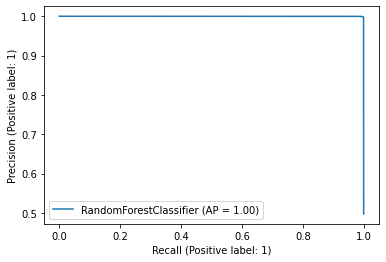

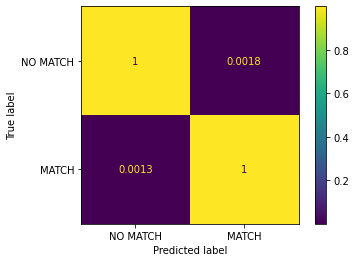

In [24]:
evaluate_model(rf, X_test, y_test)

In [25]:

# %%
# Decile plots

def declie_plot_1(model,X_test,y_test,no_bin=10):

    y_proba = model.predict_proba(X_test)
    y_proba = y_proba[:, 1]
    y_pred = model.predict(X_test)

    decile_df = pd.DataFrame(y_proba,columns=['predict_proba'])
    decile_df['actual'] = y_test.values
    decile_df['decile_rank'] =pd.cut(decile_df['predict_proba'],no_bin,labels=False)
    decile_df['Predicted'] = y_pred
    plot_df = decile_df.groupby(['decile_rank'])['actual'].value_counts(normalize=True).rename("percentage").mul(100).reset_index()

    # return dataframe
    return_df = decile_df.groupby(['decile_rank'])['actual'].value_counts().rename("number").reset_index()

    g = sns.barplot(plot_df['decile_rank'],y=plot_df['percentage'],hue=plot_df['actual'])

    sns.set(rc={'figure.figsize':(8,8)})
    # show numbers as well
    for index,row in plot_df.iterrows():
        g.text(row.decile_rank,row.percentage,round(row.percentage,2),color='black',ha='center')
    g.set_title('Decile plot (bucketed by Prob)')
    
    return return_df


def decile_plot(model, X_test, y_test, no_bin=10):

    y_proba = model.predict_proba(X_test)
    y_proba = y_proba[:, 1]
    #y_pred = model.predict(X_test)
    decile_df = pd.DataFrame(y_proba,columns=['PREDICTED_PROBA'])
    decile_df['ACTUAL'] = y_test.values

    decile_df.sort_values(by=['PREDICTED_PROBA'], inplace=True)
    decile_df.reset_index(drop=True, inplace=True)
    decile_df['decile_rank'] = pd.cut(decile_df.index,no_bin, labels=False)
    plot_df =decile_df.groupby(['decile_rank'])['ACTUAL'].value_counts(normalize=True).rename("percentage").mul(100).reset_index()

    g = sns.barplot(plot_df['decile_rank'],y=plot_df['percentage'],hue=plot_df['ACTUAL'])
    sns.set(rc={'figure.figsize':(8,8)})
    for index,row in plot_df.iterrows():
        g.text(row.decile_rank,row.percentage,round(row.percentage,2),color='black',ha='center')
    g.set_title('Decile plot (bucketed by Count)')
    return plot_df



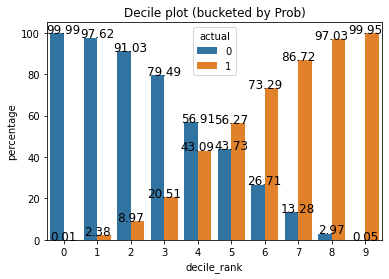

In [26]:

# %% Probability plot
return_df = declie_plot_1(rf,X_test,y_test)


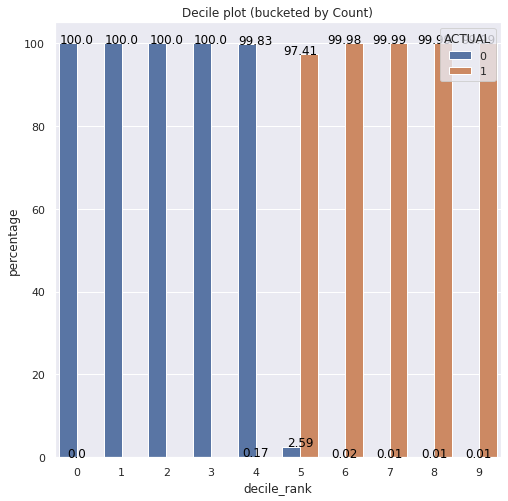

In [27]:

# %% Decile
plot_df = decile_plot(rf,X_test,y_test)

In [28]:
# %% feature importance
feature_df = pd.DataFrame(rf.feature_importances_,X_train.columns).sort_values(by=0)
feature_df.reset_index(inplace=True)
feature_df[0] = feature_df[0]*100
feature_df.tail(10)

,index,0
15,ISMATCH_ORIGINAL_PROVIDER_ZIP_CODE_FUZZY,3.518457
16,ISMATCH_ADD1_RENDERING_FUZZY,3.579497
17,ISMATCH_STATE_FUZZY,3.811587
18,ISMATCH_PROVIDER_NAME_FUZZY,6.306963
19,ISMATCH_PROVIDER_NAME_FUZZY_MAX,6.527697
20,ISMATCH_STATE_FUZZY_MAX,7.829672
21,ISMATCH_PROVIDER_STATE_RENDERING_FUZZY,7.895945
22,PARTIAL_NAME_FUZZY,8.982974
23,ISMATCH_TAX_FUZZY,10.516803
24,ISMATCH_TAX_FUZZY_MAX,11.604586


In [29]:
# %% output
file_name = "artifacts/rf_model.pickle"
pickle.dump(rf,open(file_name,'wb'))

#  transfoemd features
col_name = "artifacts/transformed_features.pickle"
pickle.dump(final_features,open(col_name,'wb'))

# model innput features
model_features = X_train.columns.tolist()
model_features_path = "artifacts/model_features.pickle"
pickle.dump(model_features,open(model_features_path,'wb'))

schema_path = "artifacts/schema.pickle"
pickle.dump(test_df.drop(['Target'], axis=1).dtypes,open(schema_path,'wb'))

In [30]:
# %%
schema_path = "artifacts/schema.pickle"
schema = pickle.load(open(schema_path,'rb'))
schema

ISMATCH_PROVIDER_NAME_FUZZY                 float16
ISMATCH_PROVIDER_NAME_RENDERING_FUZZY       float16
ISMATCH_FPROVIDER_NAME_FUZZY                float16
ISMATCH_LPROVIDER_NAME_FUZZY                float16
ISMATCH_FPROVIDER_NAME_RENDERING_FUZZY      float16
ISMATCH_LPROVIDER_NAME_RENDERING_FUZZY      float16
ISMATCH_ADD_FUZZY                           float16
ISMATCH_ADD2_FUZZY                          float16
ISMATCH_ADD1_RENDERING_FUZZY                float16
ISMATCH_ADD2_RENDERING_FUZZY                float16
ISMATCH_STATE_FUZZY                         float16
ISMATCH_PROVIDER_STATE_RENDERING_FUZZY      float16
ISMATCH_CITY_FUZZY                          float16
ISMATCH_PROVIDER_CITY_RENDERING_FUZZY       float16
ISMATCH_ZIP_FUZZY                           float16
ISMATCH_ORIGINAL_PROVIDER_ZIP_CODE_FUZZY    float16
ISMATCH_TAX_FUZZY                           float16
ISMATCH_PROVIDER_TAX_ID_RENDERING_FUZZY     float16
ISMATCH_PROVIDER_NAME_FUZZY_MAX             float16
ISMATCH_ADD_

In [31]:
import os
model_size=os.path.getsize('artifacts/rf_model.pickle')/(1024*1024)
print((f"{model_size} MB"))

360.2906656265259 MB


In [32]:

# ==================================================================
# %% Validation on production data

# data_path = '/opt/app/mpidatasci/PMMMA/HFCA- Phase 2/NON P Match'
fpath = r'/opt/app/mpidatasci/prakash.tiwari/'
prod_data_file_name = fpath + '6_21_to_6_25_PMMMA_Prod_Results.xlsx'
prod_data = pd.read_excel(prod_data_file_name,
    # r"MML_061521_061621_COB_Final.xlsx",    
    dtype={
        'EDP_CLAIM_ID': str,
        'MPI_CLAIM_ID': str,
        'MATCHED_ARRGMT': str,
        'ORG_TIN': str,
        'REND_TIN': str,
        'BILL_TIN': str,
        'BILL_NPI': str,
        'TIN': str,
        'NPI': str,
        'REND_NPI': str,
        'PROVIDERID': str,
        'REND_ZIP': str,
        'ARRGMTP': str,
        'ARRGMTNONP': str,
        'BILL_FN':str,
        'REND_FN':str,
        'BILL_ADD1':str,
        'REND_ADD1':str,
        'BILL_ADD2':str,
        'REND_ADD2':str,
    })

# %%
drop_cols = [
    'TOTAL_CHARGES', 'RIMS_CCODE', 'RIMS_NO', 'LOADID', 'STATUS_CODE',
    'CLIENT_NO', 'LOAD_DATE', 'ADDRESS2', 'POST_MC', 'POST_MC', 'P_SCORE',
     'NONP_SCORE', 'OTHERID', 'MIDDLENAME', 'BILL_ZIP','MODEL_ARRGMT_APPLIED',
    'NET_ID','NET','EDI_STATUS','PRICED_PROD','NCC','ALLOWED_AMT','SAVINGS',
    'PRE_MC','P_SCORE_RANGE','NONP_SCORE_RANGE'
]
prod_data.drop(columns=drop_cols, inplace=True)
prod_data.fillna("XX",inplace=True)

# %%
mapping= {
    # claim
    'ORG_TIN': 'ORIGINAL_PROVIDER_TAX_ID_C',
    'REND_TIN': 'PROVIDER_TAX_ID_RENDERING_C',
    'BILL_PROVIDER':'PROVIDER_NAME_C',
    'BILL_FN':'PROVIDER_FNAME_C',
    'BILL_LN':'PROVIDER_LNAME_C',
    'BILL_ADD1':'ADDRESS_C',
    'BILL_ADD2':'PROVIDER_ADD2_C',
    'BILL_CITY':'CITY_C',
    'BILL_ST':'STATE_C',
    'REND_PROV':'PROVIDER_NAME_RENDERING_C',
    'REND_LN':'PROVIDER_FIRST_NAME_RENDERING_C',
    'REND_FN':'PROVIDER_LAST_NAME_RENDERING_C',
    'REND_ADD1':'PROVIDER_ADD1_RENDERING_C',
    'REND_ADD2':'PROVIDER_ADD2_RENDERING_C',
    'REND_CITY':'PROVIDER_CITY_RENDERING_C',
    'REND_ST':'PROVIDER_STATE_RENDERING_C',
    'REND_ZIP':'PROVIDER_ZIP_CODE_RENDERING_C',
    'ORG_ZIP':'ORIGINAL_PROVIDER_ZIP_CODE_C',
    # provider
    'PROVIDERID':'PROVIDER_ID_P',
    'PROVIDER':'PROVIDER_NAME_P',
    'FIRSTNAME':'PROVIDER_FNAME_P',
    'LASTNAME':'PROVIDER_LNAME_P',
    'ADDRESS':'ADDRESS_P',
    'CITY':'CITY_P',
    'STATE':'STATE_P',
    'ZIPCODE':'ZIP_P',
    'TIN':'TIN_P'
}
# % manual matching claim --> provider --> determine how pricing the claim --> pay or not; how much
# ML only ones that manually -->
prod_data.rename(columns=mapping,inplace=True)


In [33]:

prod_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66009 entries, 0 to 66008
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   EDP_CLAIM_ID                     66009 non-null  object
 1   ARRGMTP                          66009 non-null  object
 2   ARRGMTNONP                       66009 non-null  object
 3   MATCHED_ARRGMT                   66009 non-null  object
 4   MATCH_STATUS                     66009 non-null  object
 5   ORIGINAL_PROVIDER_TAX_ID_C       66009 non-null  object
 6   PROVIDER_TAX_ID_RENDERING_C      66009 non-null  object
 7   BILL_TIN                         66009 non-null  object
 8   PROVIDER_ID_P                    66009 non-null  object
 9   PROVIDER_NAME_P                  66009 non-null  object
 10  PROVTYPE                         66009 non-null  object
 11  PROVIDER_FNAME_P                 66009 non-null  object
 12  PROVIDER_LNAME_P                

In [34]:
prod_data.PROVTYPE.value_counts()


XX            51051
PROF           5753
PRACGROUP      3306
ACUTE          2404
DIAG           1122
OUTPATIENT      971
PHREHAB         550
HOMECARE        487
BEHAVIORAL      158
LONG            103
OTHER            58
PRACTICE         28
TRANS            18
Name: PROVTYPE, dtype: int64

In [35]:

# %%
prod_data = prod_data[prod_data.MATCH_STATUS.isin(
    ['NoMatch', 'Matched_Repriced'])]

matched_prod_data = prod_data[
    (prod_data.MATCH_STATUS.isin(['Matched_Repriced']))
    & (prod_data.PROVTYPE.isin([
        'PRACGROUP', 'ACUTE', 'DIAG', 'OUTPATIENT', 'HOMECARE', 'PHREHAB',
        'BEHAVIORAL', 'LONG', 'OTHER', 'PRACTICE', 'TRANS'
    ]))]
nomatched_prod_data = prod_data[prod_data.MATCH_STATUS.isin(['NoMatch'])]

# %% no-match  claims
cols_drop=['PROVIDER_ID_P', 'PROVIDER_NAME_P', 'PROVTYPE', 'PROVIDER_FNAME_P',
       'PROVIDER_LNAME_P', 'ADDRESS_P', 'CITY_P', 'STATE_P', 'ZIP_P']
nomatched_prod_data.drop(columns=cols_drop,axis=1,inplace=True)


In [36]:
# %%
provider_df = pd.read_parquet(r'data/provider_phase2.gzip')
provider_df = provider_df.astype('str')
print(provider_df.shape)
provider_df = provider_df[provider_df.PROVIDER_CLASS != 'P']
print(provider_df.shape)

# %%
provider_df.columns = [str(col)+'_P' for col in provider_df.columns if col[-2:] != '_P']

# %%
nomatched_prod_data_t = pd.merge(nomatched_prod_data,provider_df,left_on=['ARRGMTNONP'],right_on=['PARRID_P'])

print(nomatched_prod_data.EDP_CLAIM_ID.unique().shape[0])

print(nomatched_prod_data.EDP_CLAIM_ID.unique().shape[0] - nomatched_prod_data_t.EDP_CLAIM_ID.unique().shape[0])

# %%
# match data add TIN number
matched_prod_data_t = pd.merge(matched_prod_data,provider_df[['PARRID_P','TIN_P']],left_on=['MATCHED_ARRGMT'],right_on=['PARRID_P'])

matched_prod_data.EDP_CLAIM_ID.unique().shape[0] - matched_prod_data_t.EDP_CLAIM_ID.unique().shape[0]

# %%
# matched_prod_data_t.drop(columns=['PROVTYPE'],axis=1,inplace=True)
# col_order = list(matched_prod_data_t.columns)

# nomatched_prod_data_t = nomatched_prod_data_t[col_order]

matched_prod_data_t.drop(columns=['PROVTYPE'],axis=1,inplace=True)
col_order = list(matched_prod_data_t.columns)

# %%
nomatched_prod_data_t = nomatched_prod_data_t[col_order]

prod_consumable = pd.concat([matched_prod_data_t,nomatched_prod_data_t])

pd.concat([matched_prod_data_t,nomatched_prod_data_t]).EDP_CLAIM_ID.unique().shape





(32643720, 12)
(3400878, 12)
37323
20796


(25360,)

In [37]:
# %%
prod_consumable_p = "data/prod_consumable_5d.pkl"
pickle.dump(prod_consumable,open(prod_consumable_p,'wb'))

In [38]:
# %% inference

def clean_data(df_c):
    df_c.replace(["XX"],[None],inplace=True)
    df_c.replace(["NONE"],[None],inplace=True)
    df_c.replace(["None"],[None],inplace=True)
    df_c.replace(["99999"],[None],inplace=True)
    df_c.replace(["999999999"],[None],inplace=True)
    df_c.replace(["nan"],[None],inplace=True)
    df_c.replace(["NaN"],[None],inplace=True)
    df_c.replace(["null"],[None],inplace=True)
    df_c.replace(["Null"],[None],inplace=True)
    df_c.replace(["0"],[None],inplace=True)
    # ORIGINAL_PROVIDER_ZIP_CODE has some values > 5, just take first 5 numbers ignore others
    df_c.ORIGINAL_PROVIDER_ZIP_CODE_C = df_c.ORIGINAL_PROVIDER_ZIP_CODE_C.apply(lambda x: str(x)[:5] if x else x)
    df_c.PROVIDER_ZIP_CODE_RENDERING_C = df_c.PROVIDER_ZIP_CODE_RENDERING_C.apply(lambda x: str(x)[:5] if x else x)

    return df_c


# %%
def inference_prod(validation_merged):
    validation_merged = clean_data(validation_merged)
#     # take only data matched to P type of provider since NON P wongt have first name & last name info
#     validation_merged = validation_merged[validation_merged.PROVTYPE == 'PROF']

    # target creation
    # validation_merged['Target'] = validation_merged.MATCHED_ARRGMT.apply(lambda x: 0 if x == '99999999' else 1)  # This is Rohit's definition
    validation_merged['Target'] = (validation_merged['MATCH_STATUS']=='Matched_Repriced').astype(int)  # yy: as we use final MATCH_STATUS final ground truth
    print(validation_merged.shape)

    # clean provider name
    validation_merged.PROVIDER_NAME_C = validation_merged.PROVIDER_NAME_C.apply(clean_provider_name)
    validation_merged.PROVIDER_FNAME_C = validation_merged.PROVIDER_FNAME_C.apply(clean_provider_name)
    validation_merged.PROVIDER_LNAME_C = validation_merged.PROVIDER_LNAME_C.apply(clean_provider_name)

    validation_merged.PROVIDER_NAME_RENDERING_C = validation_merged.PROVIDER_NAME_RENDERING_C.apply(clean_provider_name)
    validation_merged.PROVIDER_FIRST_NAME_RENDERING_C = validation_merged.PROVIDER_FIRST_NAME_RENDERING_C.apply(clean_provider_name)
    validation_merged.PROVIDER_LAST_NAME_RENDERING_C = validation_merged.PROVIDER_LAST_NAME_RENDERING_C.apply(clean_provider_name)

    # provider
    validation_merged.PROVIDER_NAME_P = validation_merged.PROVIDER_NAME_P.apply(clean_provider_name)
    validation_merged.PROVIDER_FNAME_P = validation_merged.PROVIDER_FNAME_P.apply(clean_provider_name)
    validation_merged.PROVIDER_LNAME_P = validation_merged.PROVIDER_LNAME_P.apply(clean_provider_name)

    # normalize address

    validation_merged['ADDRESS_P'] = validation_merged.ADDRESS_P.apply(normalize_address)

    validation_merged['ADDRESS_C'] = validation_merged.ADDRESS_C.apply(normalize_address)
    validation_merged['PROVIDER_ADD2_C'] = validation_merged.PROVIDER_ADD2_C.apply(normalize_address)

    validation_merged['PROVIDER_ADD1_RENDERING_C'] = validation_merged.PROVIDER_ADD1_RENDERING_C.apply(normalize_address)
    validation_merged['PROVIDER_ADD2_RENDERING_C'] = validation_merged.PROVIDER_ADD2_RENDERING_C.apply(normalize_address)

    validation_merged['PARTIAL_NAME_FUZZY'] = validation_merged.apply(partial_name_match,axis=1)
    # pipeline
    validation_transformed = Full_pipeline.fit_transform(validation_merged)
    validation_transformed = pd.DataFrame(validation_transformed,columns=final_features)


    for act_dict in max_activation_l:
        new_col_name = list(act_dict.keys())[0]+"_MAX"
        validation_transformed[new_col_name] = validation_transformed[combine_keys([act_dict])].max(axis=1)

    validation_transformed['PARTIAL_NAME_FUZZY'] = validation_merged.PARTIAL_NAME_FUZZY.values

    if validation_transformed.dtypes.equals(schema):
         pass
    else:
         raise Exception("Schema does not match")

    # check schema
    if validation_transformed.dtypes.equals(test_df.drop(['Target'],axis=1).dtypes):
         pass
    else:
         raise Exception("Schema does not match")

    # validation set
    X_val = validation_transformed.copy(deep=True)
    y_val = validation_merged['Target']
    print(X_val.columns)

    # missing col
    missing_col = set(X_train.columns) - set(X_val.columns)

    for col in missing_col:
        X_val[col] = 0

    # re order
    _X_val = X_val[X_train.columns]
    y_pred_proba_raw = rf.predict_proba(_X_val) # [:,1]
    y_pred_proba = y_pred_proba_raw[:, 1]

    return y_pred_proba, y_pred_proba_raw, _X_val,y_val


In [39]:
prod_consumable.PROVIDER_FNAME_C.iloc[8796]

'526005'

In [40]:
%%time
prod_pred_proba, prod_pred_proba_raw, _X_val,y_val = inference_prod(prod_consumable)

(125230, 38)
Index(['ISMATCH_PROVIDER_NAME_FUZZY', 'ISMATCH_PROVIDER_NAME_RENDERING_FUZZY',
       'ISMATCH_FPROVIDER_NAME_FUZZY', 'ISMATCH_LPROVIDER_NAME_FUZZY',
       'ISMATCH_FPROVIDER_NAME_RENDERING_FUZZY',
       'ISMATCH_LPROVIDER_NAME_RENDERING_FUZZY', 'ISMATCH_ADD_FUZZY',
       'ISMATCH_ADD2_FUZZY', 'ISMATCH_ADD1_RENDERING_FUZZY',
       'ISMATCH_ADD2_RENDERING_FUZZY', 'ISMATCH_STATE_FUZZY',
       'ISMATCH_PROVIDER_STATE_RENDERING_FUZZY', 'ISMATCH_CITY_FUZZY',
       'ISMATCH_PROVIDER_CITY_RENDERING_FUZZY', 'ISMATCH_ZIP_FUZZY',
       'ISMATCH_ORIGINAL_PROVIDER_ZIP_CODE_FUZZY', 'ISMATCH_TAX_FUZZY',
       'ISMATCH_PROVIDER_TAX_ID_RENDERING_FUZZY',
       'ISMATCH_PROVIDER_NAME_FUZZY_MAX', 'ISMATCH_ADD_FUZZY_MAX',
       'ISMATCH_STATE_FUZZY_MAX', 'ISMATCH_CITY_FUZZY_MAX',
       'ISMATCH_ZIP_FUZZY_MAX', 'ISMATCH_TAX_FUZZY_MAX', 'PARTIAL_NAME_FUZZY'],
      dtype='object')
CPU times: user 40.4 s, sys: 11.1 s, total: 51.4 s
Wall time: 54.2 s


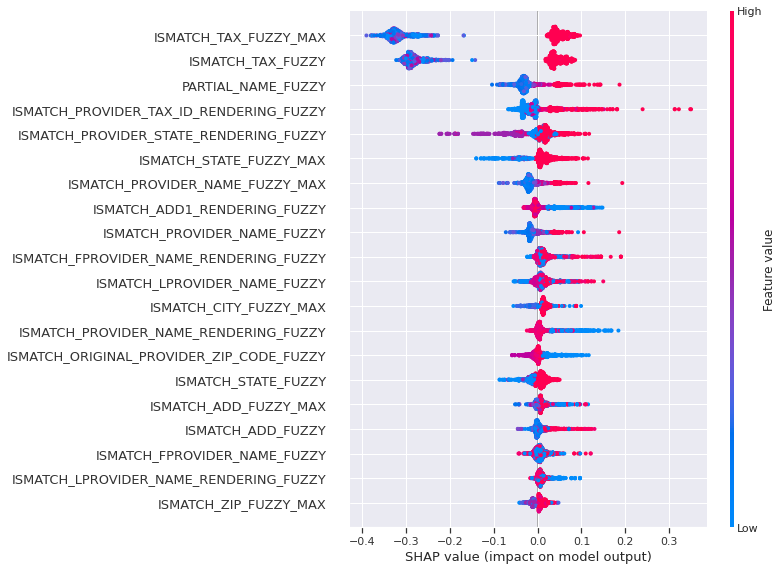

CPU times: user 1h 23min 52s, sys: 3.86 s, total: 1h 23min 56s
Wall time: 1h 23min 50s


In [55]:
%%time
import shap
X=_X_val.sample(n=2000)
shap_values = shap.TreeExplainer(rf).shap_values(X)
shap.summary_plot(shap_values[1],X)

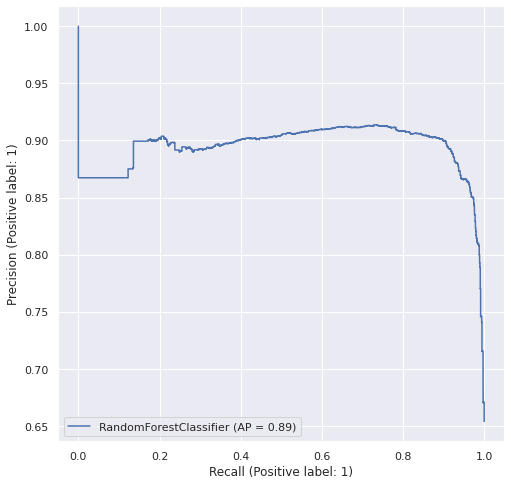

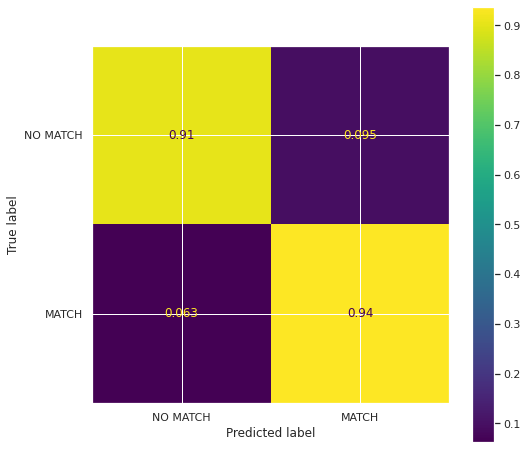

In [42]:
f1_score,precision_score,recall_score=evaluate_model(rf, _X_val, y_val)

In [43]:
mean_prob=np.mean(prod_pred_proba)

median_prob=np.median(prod_pred_proba)


<AxesSubplot:ylabel='Density'>

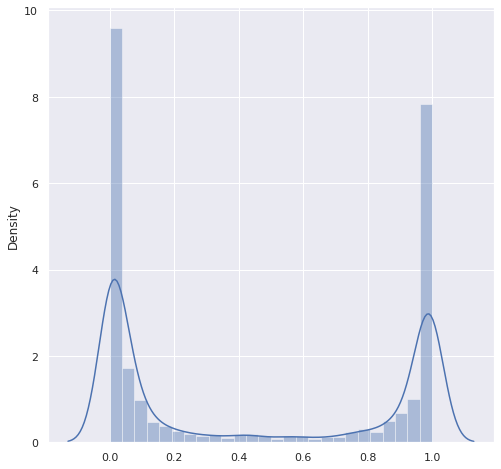

In [44]:

# %%
# import seaborn as sns
sns.distplot(prod_pred_proba)


In [45]:

# %%
prod_consumable['NEW_NONP_SCORE'] = prod_pred_proba

# %%
prod_consumable.sort_values(by=['EDP_CLAIM_ID','NEW_NONP_SCORE'],ascending=False,inplace=True)

prod_consumable.EDP_CLAIM_ID.unique().shape

# %% claim level (drop dupliated EDP_CLAIM_ID and keep the highest probability score )
validation_df = prod_consumable.drop_duplicates(subset=['EDP_CLAIM_ID'],keep='first')



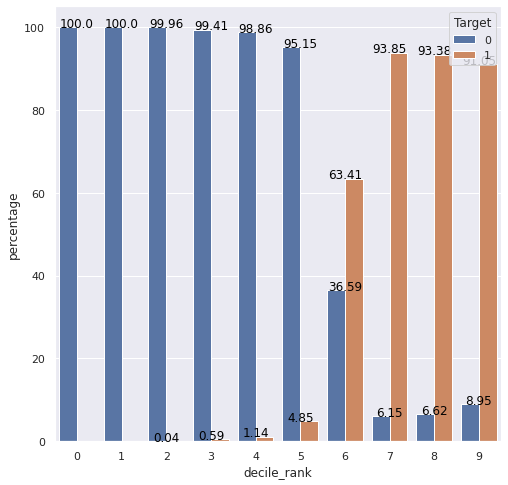

In [46]:
# %%
def decile_plot(claim_level_final,n_bins=20, target = 'Target'):

    claim_level_final.sort_values(by=['NEW_NONP_SCORE'],inplace=True)
    claim_level_final.reset_index(drop=True,inplace=True)
    claim_level_final['decile_rank'] = pd.cut(claim_level_final.index,n_bins,labels=False)
    # counts
    df_cnt =claim_level_final.groupby(['decile_rank'])[target].value_counts(normalize=False).rename("Count").reset_index()
    # percent
    plot_df =claim_level_final.groupby(['decile_rank'])[target].value_counts(normalize=True).rename("percentage").mul(100).reset_index()

    import seaborn as sns
    g = sns.barplot(plot_df['decile_rank'],y=plot_df['percentage'],hue=plot_df[target])
    sns.set(rc={'figure.figsize':(8,8)})
    for index,row in plot_df.iterrows():
        g.text(row.decile_rank,row.percentage,round(row.percentage,2),color='black',ha='center')

    return plot_df, df_cnt

# %%
# _df_decile_claim_level = 

_df_decile, _df_decile_cnt = decile_plot(validation_df, 10)

In [47]:
def prob2decile(predicted_prob, actual):
    """
    # calculate deciles (with equal counts in each bin)

    Parameters
    ----------
    predicted_prob : numeric (pandas series or np array)
        the predicted probability of outcome (match).
    actual : ground truth of matchs (1s) or non-match (0s)
        the actual value of the labels.

    Returns
    -------
    df2 : pandas dataframe
        the output of this function is a pandas dataframe that contain the deciles and various 
        percentile (at total count level or at bin (decile) level.

    """


    df = pd.DataFrame()
    df['Prob'] = predicted_prob
    df['MATCH'] = actual.values

    # add jitters, to avoid zero count in some of  bins; then normalize it so that it is still 1-0.
    df['Prob'] = df['Prob']+np.random.random(len(df)) * 1E-7
    df['Prob'] = df['Prob']/df['Prob'].max()  # normalize

    # change here can b eithr decile of percentile
    df['decile'] = pd.qcut(df['Prob'], 10, labels=False) #, duplicates='drop')
    df['NONMATCH'] = 1 - df['MATCH']

    # pivot it
    df1 = pd.pivot_table(data=df, index=['decile'],
                         values=['MATCH', 'NONMATCH', 'Prob'],
                         aggfunc={'MATCH': [np.sum],
                                  'NONMATCH':[np.sum],
                                  'Prob': [np.min, np.max]})

    
    df1.columns = ['MATCH_COUNT', 'NONMATCH_COUNT', 'MAX_SCORE', 'MIN_SCORE']
    df1['Total_count'] = df1['MATCH_COUNT'] + df1['NONMATCH_COUNT']

    df2 = df1.sort_values(by='MIN_SCORE', ascending=False)

    # match rate at overall level
    df2['MATCH_Rate'] = (df2['MATCH_COUNT'] / df2['Total_count']).apply('{0:.2%}'.format)
    df2['NONMATCH_Rate'] = (df2['NONMATCH_COUNT'] / df2['Total_count']).apply('{0:.2%}'.format)

    match_sum = df2['MATCH_COUNT'].sum()
    non_match_sum = df2['NONMATCH_COUNT'].sum()
    df2['MATCH %'] = (df2['MATCH_COUNT']/match_sum).apply('{0:.2%}'.format)
    df2['NONMATCH %'] = (df2['NONMATCH_COUNT']/non_match_sum).apply('{0:.2%}'.format)

    # match and nonmatch rate at decile level
    # df2['MATCH % (bin)'] = (df2['MATCH_COUNT']/df2['Total_count']).apply('{0:.2%}'.format)
    # df2['NONMATCH % (bin)'] = (df2['NONMATCH_COUNT']/df2['Total_count']).apply('{0:.2%}'.format)

    df2['ks_stats'] = np.round(((df2['MATCH_COUNT'] / df2['MATCH_COUNT'].sum()).cumsum() -(df2['NONMATCH_COUNT'] / df2['NONMATCH_COUNT'].sum()).cumsum()), 4) * 100
    
    flag = lambda x: '*****' if x == df2['ks_stats'].max() else ''
    df2['max_ks'] = df2['ks_stats'].apply(flag)
   
    
    df2['default_cum%'] = np.round(((df2['MATCH_COUNT'] / df2['MATCH_COUNT'].sum()).cumsum()), 4) * 100
    

    return df2

# %%
# validation_df['TARGET'] = (validation_df['MATCH_STATUS']=='Matched_Repriced').astype(int)
df_decile = prob2decile(validation_df['NEW_NONP_SCORE'], validation_df['Target'])
df_decile


,MATCH_COUNT,NONMATCH_COUNT,MAX_SCORE,MIN_SCORE,Total_count,MATCH_Rate,NONMATCH_Rate,MATCH %,NONMATCH %,ks_stats,max_ks,default_cum%
decile,,,,,,,,,,,,
9,2309,227,1.000000,9.999500e-01,2536,91.05%,8.95%,26.14%,1.37%,24.77,,26.14
8,2368,168,0.999950,9.957240e-01,2536,93.38%,6.62%,26.81%,1.02%,50.56,,52.95
7,2380,156,0.995722,9.694026e-01,2536,93.85%,6.15%,26.94%,0.94%,76.56,,79.89
6,1608,928,0.969377,6.257264e-01,2536,63.41%,36.59%,18.20%,5.62%,89.15,*****,98.10
5,123,2413,0.625726,2.231704e-01,2536,4.85%,95.15%,1.39%,14.60%,75.94,,99.49
4,29,2507,0.222729,9.271343e-02,2536,1.14%,98.86%,0.33%,15.17%,61.10,,99.82
3,15,2521,0.092697,4.335165e-02,2536,0.59%,99.41%,0.17%,15.25%,46.02,,99.99
2,1,2535,0.043343,1.478942e-02,2536,0.04%,99.96%,0.01%,15.34%,30.69,,100.00
1,0,2536,0.014789,3.846205e-03,2536,0.00%,100.00%,0.00%,15.34%,15.34,,100.00


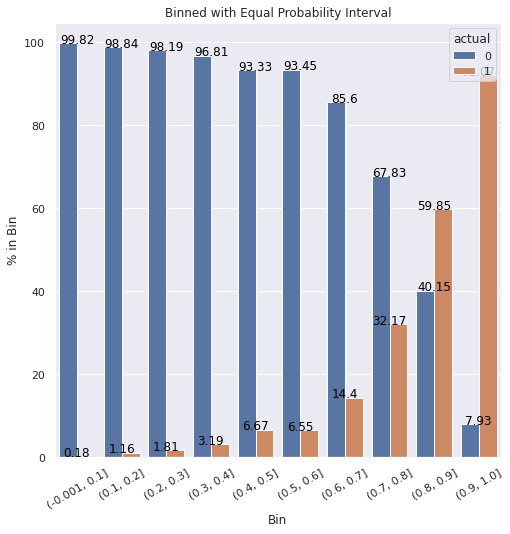

In [48]:
def prob2percentile(y_test, y_proba, bins=10):
    """ 
    The function plots decile based on equal interval of probabilities (scores)
    """

    decile_df = pd.DataFrame(y_proba.values,columns=['predict_proba'])
    decile_df['actual'] = y_test.values
    decile_df['decile_rank'] =pd.cut(decile_df['predict_proba'],bins,labels=None)
    decile_df['Predicted'] = y_proba
    plot_df = decile_df.groupby(['decile_rank'])['actual'].value_counts(normalize=True).rename("percentage").mul(100).reset_index()

    # return dataframe
    _df = decile_df.groupby(['decile_rank'])['actual'].value_counts().rename("number").reset_index()

    g = sns.barplot(plot_df['decile_rank'],y=plot_df['percentage'],hue=plot_df['actual'])

    # add decile ranking number (from 0 to 9, total 10 decile)
    plot_df['decile_no'] = np.repeat(np.arange(0, 10, 1), 2)
    sns.set(rc={'figure.figsize':(8,8)})

    # show percentage on the bars
    for index,row in plot_df.iterrows():
        g.text(row.decile_no,row.percentage, round(row.percentage,2),color='black',ha='center')
    
    g.set_title('Binned with Equal Probability Interval')
    g.set(xlabel='Bin', ylabel="% in Bin")
    g.set_xticklabels(g.get_xticklabels(), rotation=30)    

    return _df

# %%
_df_perc = prob2percentile(validation_df['Target'], validation_df['NEW_NONP_SCORE'], bins=10)
_df_perc.to_csv(configuration["artifact_path"]+"percentile.csv")

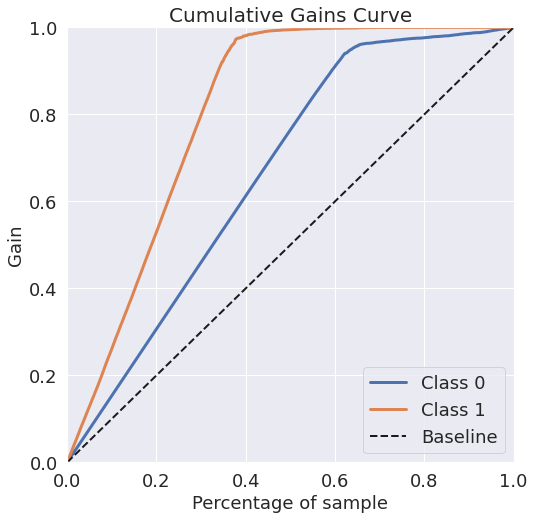

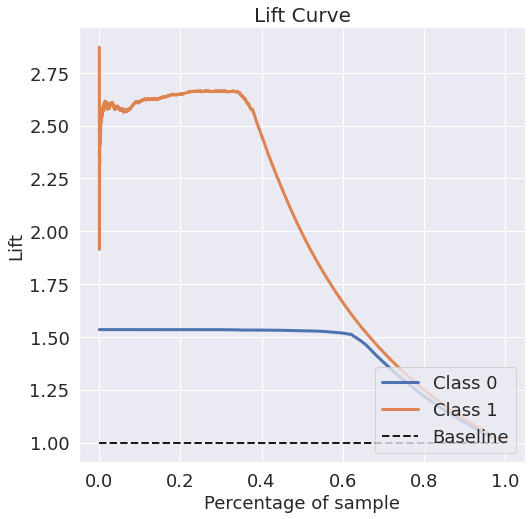

In [49]:
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
validation_df["NEW_NONP_SCORE_1"]=validation_df["NEW_NONP_SCORE"].apply(lambda x : 1-x)#rf.predict_proba(_X_val)
P=validation_df[["NEW_NONP_SCORE_1","NEW_NONP_SCORE"]].to_numpy()
# plot_cumulative_gain((prod_consumable['MATCH_STATUS']=='Matched_Repriced').astype(int), P)
y = validation_df["Target"] #(prod_consumable['MATCH_STATUS']=='Matched_Repriced').astype(int)
ax=plot_cumulative_gain(y, P, figsize=(8, 8), title_fontsize=20, text_fontsize=18)
ax.figure.savefig(configuration["artifact_path"]+"cumulative_gain.jpg")
# plot_cumulative_gain(y, P)
ax=plot_lift_curve(y, P, figsize=(8, 8), title_fontsize=20, text_fontsize=18)
ax.figure.savefig(configuration["artifact_path"]+"lift_curve.jpg")

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,1.000,1.000,1.000,2536.0,2309.0,227.0,883.3,2536,91.049,2536.0,2309.0,2536,227.0,10.0,26.141,28.711,1.374,24.767,2.614
1,2,0.996,1.000,0.998,2536.0,2368.0,168.0,883.3,2536,93.375,5072.0,4677.0,5072,395.0,20.0,52.949,57.421,2.390,50.559,2.647
2,3,0.969,0.996,0.986,2536.0,2380.0,156.0,883.3,2536,93.849,7608.0,7057.0,7608,551.0,30.0,79.894,86.132,3.334,76.560,2.663
3,4,0.626,0.969,0.858,2536.0,1608.0,928.0,883.3,1225,63.407,10144.0,8665.0,8833,1479.0,40.0,98.098,100.000,8.949,89.149,2.452
4,5,0.223,0.626,0.398,2536.0,123.0,2413.0,883.3,0,4.850,12680.0,8788.0,8833,3892.0,50.0,99.491,100.000,23.549,75.942,1.990
5,6,0.093,0.223,0.145,2536.0,29.0,2507.0,883.3,0,1.144,15216.0,8817.0,8833,6399.0,60.0,99.819,100.000,38.718,61.101,1.664
6,7,0.043,0.093,0.065,2536.0,15.0,2521.0,883.3,0,0.591,17752.0,8832.0,8833,8920.0,70.0,99.989,100.000,53.972,46.017,1.428
7,8,0.015,0.043,0.027,2536.0,1.0,2535.0,883.3,0,0.039,20288.0,8833.0,8833,11455.0,80.0,100.000,100.000,69.311,30.689,1.250
8,9,0.004,0.015,0.008,2536.0,0.0,2536.0,883.3,0,0.000,22824.0,8833.0,8833,13991.0,90.0,100.000,100.000,84.655,15.345,1.111
9,10,0.000,0.004,0.001,2536.0,0.0,2536.0,883.3,0,0.000,25360.0,8833.0,8833,16527.0,100.0,100.000,100.000,100.000,0.000,1.000


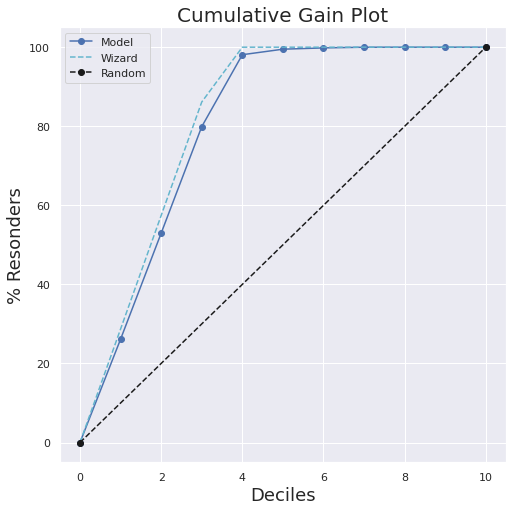

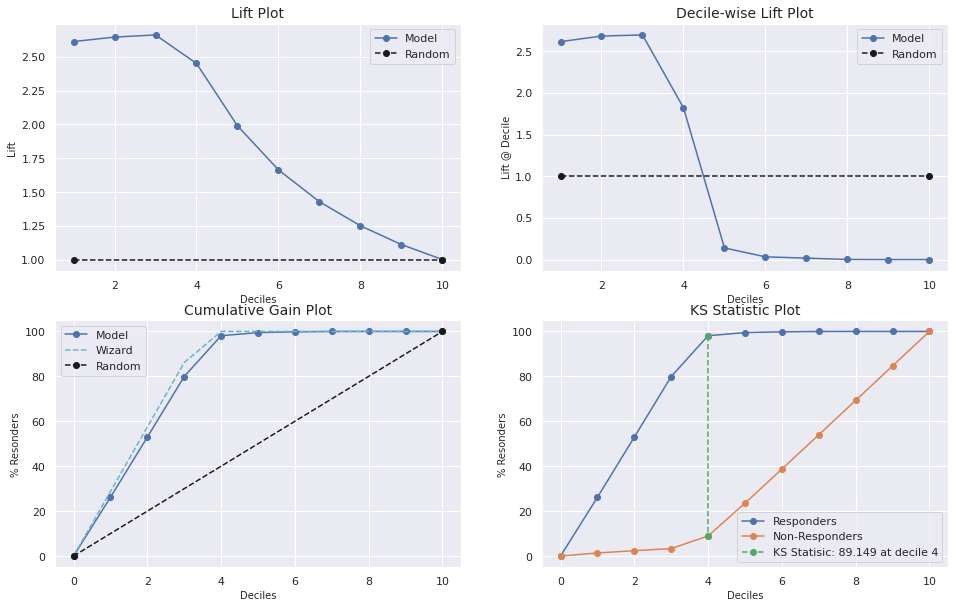

In [50]:
# %%
import kds
P=validation_df["NEW_NONP_SCORE"]
kds.metrics.plot_cumulative_gain(y, P, title_fontsize=20, text_fontsize=18)
kds.metrics.report(y, P, title_fontsize=20, text_fontsize=18)

In [51]:
df_decile.to_csv(configuration["artifact_path"]+"decile.csv")


In [52]:
def decile_error(df,deci=1,lower_deci=True):
    if lower_deci:
        count_tab=df.iloc[-1*deci:,:][["MATCH_COUNT","NONMATCH_COUNT"]].sum()
        return count_tab.loc["MATCH_COUNT"]/(count_tab.loc["MATCH_COUNT"]+count_tab.loc["NONMATCH_COUNT"])*100
    else:
        count_tab=df.iloc[:deci,:][["MATCH_COUNT","NONMATCH_COUNT"]].sum()
        return count_tab.loc["NONMATCH_COUNT"]/(count_tab.loc["MATCH_COUNT"]+count_tab.loc["NONMATCH_COUNT"])*100        

In [53]:
decile_error(df_decile,4,False)

14.580047318611989

/home/prakash.tiwari/.conda/envs/devEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/prakash.tiwari/.conda/envs/devEnv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/prakash.tiwari/.conda/envs/devEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [105]:
from datetime import datetime
dt=str(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))

experiment = configuration["package_name"] # + "_" + dt

hyper_para = {"n_estimators":n_estimators,"max_depth":max_depth,"criterion":criterion,
             "min_samples_leaf":min_samples_leaf,"min_samples_split":min_samples_split}

eval_metrics = {"f1_score":f1_score*100,"precision_score":precision_score*100,"recall_score":recall_score*100,
                "model_size_mb":model_size,"mean_score":mean_prob,"median_score":median_prob,
                "20_per_error":decile_error(df_decile,2), "40_per_error":decile_error(df_decile,4),
                "50_per_error":decile_error(df_decile,5)
               }
    
tags = {"Model": "HFCA NON-P",
        "DateTime": dt,
            "Type": "RandomForestClassifier"}
run_tag ={"Model": "HFCA NON-P",
          "DateTime": dt,
            "Type": "RandomForestClassifier"}
model=rf
folder_name ="mlflow"
artifact_path=configuration["artifact_path"]
notebook_path=configuration["notebook_path"]

In [106]:
log_experiment(experiment, hyper_para, eval_metrics, rf,tags,run_tag,run_tag,folder_name,artifact_path,notebook_path)

Artifact path : /opt/app/mpidatasci/prakash.tiwari/artifacts/
notebook_path : /opt/app/mpidatasci/prakash.tiwari/Non_P_HFCA_mlflow_wrapping.ipynb
Set up of MLFLOW experimet done and mlflow started
Run_id:3fb2dd694abd40c9a9003b4471bf9cc9 and Experiment_id:1
Logging started
Tracking URI : /opt/app/mpidatasci/prakash.tiwari/mlflow/mlruns
Logging artifacts
Logging completed


True

In [107]:
import imp
imp.reload(src.experiment_tracking)
from src.experiment_tracking import log_experiment

NameError: name 'src' is not defined

Text(0.5, 1.0, 'No Matched')

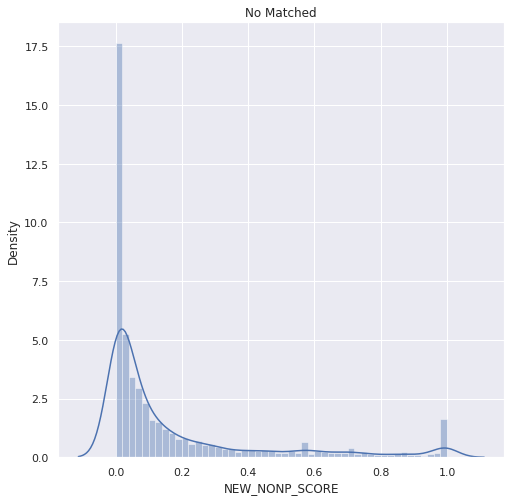

In [108]:


# %% decile plot (with equal size of bins)
# validation_df['TARGET'] = (validation_df['MATCH_STATUS']=='Matched_Repriced').astype(int)
# _df_decile_claim_level = decile_plot_1(validation_df, 10, 'TARGET')

# %%
sns.distplot(validation_df[validation_df.MATCHED_ARRGMT == "99999999"].NEW_NONP_SCORE).set_title('No Matched')


Text(0.5, 1.0, 'Matched')

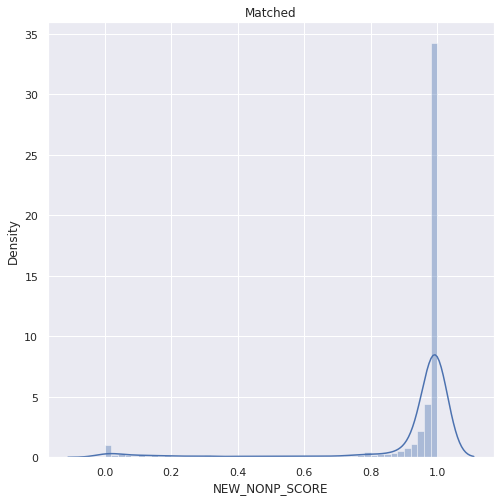

In [109]:

# %%
sns.distplot(validation_df[validation_df.MATCHED_ARRGMT != "99999999"].NEW_NONP_SCORE).set_title('Matched')


In [110]:

# %%
validation_df[validation_df.NEW_NONP_SCORE < 0.5].MATCH_STATUS.value_counts(normalize=True)


NoMatch             0.992023
Matched_Repriced    0.007977
Name: MATCH_STATUS, dtype: float64

In [111]:

# %%
validation_df[validation_df.NEW_NONP_SCORE < 0.5].MATCH_STATUS.value_counts()


NoMatch             14425
Matched_Repriced      116
Name: MATCH_STATUS, dtype: int64

In [112]:

# %%
validation_df.MATCH_STATUS.value_counts()


NoMatch             16527
Matched_Repriced     8833
Name: MATCH_STATUS, dtype: int64

In [113]:

# %%
_df_FN = validation_df[(validation_df.NEW_NONP_SCORE < 0.5) & (validation_df.MATCH_STATUS != 'NoMatch')]
print(_df_FN.shape)
_df_FN.to_csv('prod_validation_5d_data_FN.csv', index=False)
# validation_df[(validation_df.NEW_NONP_SCORE < 0.5) & (validation_df.MATCH_STATUS != 'NoMatch')].shape


(116, 42)


In [114]:

# %%
_df_FP = validation_df[(validation_df.NEW_NONP_SCORE >= 0.5) & (validation_df.MATCH_STATUS == 'NoMatch')] #.shape
print(_df_FP.shape)
_df_FP.to_csv('prod_validation_5d_data_FP.csv', index=False)


(2102, 42)


In [137]:

# %%
validation_df[(validation_df.NEW_NONP_SCORE < 0.5) & (validation_df.MATCH_STATUS != 'NoMatch')].to_excel("error_5d.xlsx",index=False)

# %% export validation (with NoMatch and Matched_Repriced)
validation_df.to_excel('validation_5d_prod.xlsx', index=False)

pd.set_option('display.max_colwidth', None)

In [139]:
prod_consumable[(prod_consumable.NEW_NONP_SCORE>0.8) & (prod_consumable.NEW_NONP_SCORE<0.95)].head(1)


,EDP_CLAIM_ID,ARRGMTP,ARRGMTNONP,MATCHED_ARRGMT,MATCH_STATUS,ORIGINAL_PROVIDER_TAX_ID_C,PROVIDER_TAX_ID_RENDERING_C,BILL_TIN,PROVIDER_ID_P,PROVIDER_NAME_P,PROVIDER_FNAME_P,PROVIDER_LNAME_P,NPI,ADDRESS_P,CITY_P,STATE_P,ZIP_P,PROVIDER_NAME_C,PROVIDER_FNAME_C,PROVIDER_LNAME_C,BILL_NPI,ADDRESS_C,PROVIDER_ADD2_C,CITY_C,STATE_C,PROVIDER_NAME_RENDERING_C,PROVIDER_FIRST_NAME_RENDERING_C,PROVIDER_LAST_NAME_RENDERING_C,REND_NPI,PROVIDER_ADD1_RENDERING_C,PROVIDER_ADD2_RENDERING_C,PROVIDER_CITY_RENDERING_C,PROVIDER_STATE_RENDERING_C,PROVIDER_ZIP_CODE_RENDERING_C,ORIGINAL_PROVIDER_ZIP_CODE_C,PARRID_P,TIN_P,Target,PARTIAL_NAME_FUZZY,NEW_NONP_SCORE
19824,232821238,122169578,45560316,99999999,NoMatch,760482007,760482007,760482007,9545325,UNIVERSITY SOUTH ALABAMA ANESTHESIA PARTNERS OCHSNER FOUNDATION HOSPITAL COLORADO,None,None,None,1000 WATERMAN WAY,TAVARES,FL,32778,UNIVERSITY SOUTH ALABAMA ANESTHESIA PARTNERS OCHSNER FOUNDATION HOSPITAL TX UNIVERSITY SOUTH ALABAMA ANESTHESIA P,None,None,None,PO BOX 840853,None,DALLAS,TX,MEMORIAL HERMANN WOO,None,None,None,9250 PINECROFT DRIVE,None,SPRING,TX,77380,75284,45560316,760482007,0,0.93,0.938346


In [ ]:
prod_consumable